
 Quantum Emotion Predictor 


Did you sleep well last night? (yes/no):  n
Did you feel productive today? (yes/no):  y
Did you laugh at least once today? (yes/no):  y
Are your stress levels low right now? (yes/no):  n
Do you feel supported by friends/family? (yes/no):  y



AI estimates: P(Happy)=0.708, P(Sad)=0.292

 Quantum Emotional Superposition:
|ψ⟩ = cos(θ/2)|Happy⟩ + sin(θ/2)|Sad⟩
Angle θ: 1.1415 radians
  φ (tone/phase) = 0.7867 radians

Statevector amplitudes:
  |Happy⟩: 0.7772-0.3225j (|amp|=0.842)
  |Sad⟩:   0.4990+0.2071j (|amp|=0.540)

After measurement (empirical frequencies):
  Happy ≈ 0.718
  Sad   ≈ 0.282

Named Emotional Superposition:
mood: Happy  |  tone: Complex  |  Overall: Layered happiness — multiple positive feelings blending together.

Interpretation:
A day filled brought together by laughter, sprinkled with joy is one meant to be remembered.
There will always be more such days to come in future and each one meant to make your life more special.



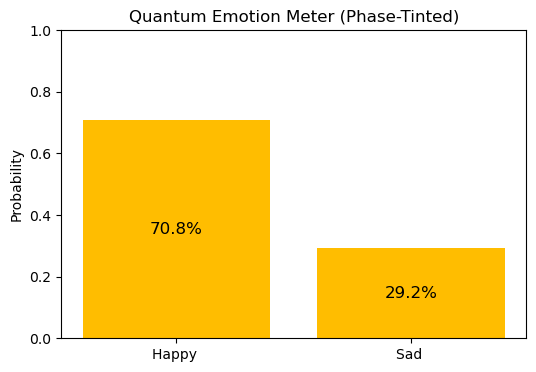

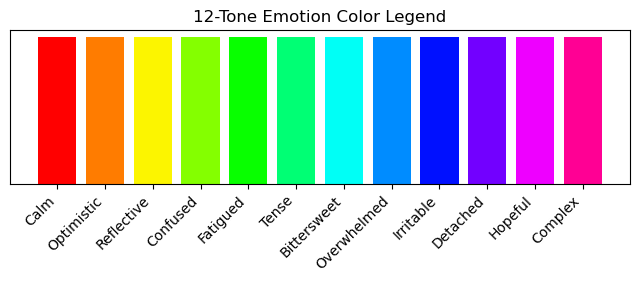

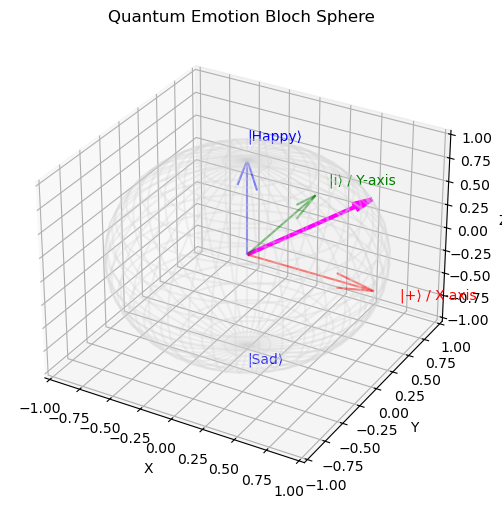

In [2]:
#V1 - tone was inaccurate and phi was weighted only by stress
#recent
from qiskit import QuantumCircuit, transpile #quantum computing libraries
from qiskit_aer import AerSimulator          #simulates the quantum circuit on a classical computer
from qiskit.quantum_info import Statevector  #compute complex amplitude vector
from sklearn.linear_model import LogisticRegression  #classical ML model for binary classification
import numpy as np                                  #numerical arrays
import matplotlib.pyplot as plt                     # for plotting 2D
from mpl_toolkits.mplot3d import Axes3D             #for plotting 3D

# 1. Questionnaire

questions = [
    "Did you sleep well last night?",
    "Did you feel productive today?",
    "Did you laugh at least once today?",
    "Are your stress levels low right now?",
    "Do you feel supported by friends/family?"
]

# 2. Training data (larger sample set)
#X is a NumPy 2D array - syntehtic data used to train the logistic regression model
X = np.array([
    [1,1,1,1,1],  # very positive mood
    [0,0,0,0,0],  # very negative mood
    [1,1,0,1,1],
    [1,0,1,0,1],
    [0,1,0,1,0],
    [0,0,1,0,0],
    [1,0,1,1,0],
    [0,1,1,0,1],
    [1,1,0,0,1],
    [0,0,1,1,0],
    [1,1,1,0,1],
    [1,0,0,1,1],
    [0,1,1,1,0],
    [1,0,0,0,1],
    [0,0,0,1,0],
    [1,1,0,1,0],
    [0,1,1,0,0],
    [1,0,1,0,0],
    [0,0,1,0,1],
    [1,1,0,0,0],
    [1,0,0,1,0],
    [0,1,0,1,1],
    [1,0,1,1,1],
    [0,1,1,1,1],
    [1,1,0,1,1],
    [0,0,0,1,1],
])

# Labels: 1 = Happy, 0 = Sad
rng = np.random.default_rng(42) #creates a reproduceable random number generator
def label_rule(row):   
    yes = sum(row)
    # more yes -> more happy
    base = 1 if yes >= 3 else 0
    # add randomness/noise so that the model learns probabilities and not a perfect rule
    if rng.random() < 0.1:    
        base = 1 - base
    return base

y = np.array([label_rule(r) for r in X])


# 3. Train simple AI model

clf = LogisticRegression(max_iter=2000)   #runs upto 2000 iterations for convergence
clf.fit(X, y)   #trains the model of the synthetic data => clf can predict probabilities for new input vectors


# 4. Get user answers

print("\n Quantum Emotion Predictor ")
user_answers = []

for q in questions:
    while True:
        ans = input(f"{q} (yes/no): ").strip().lower()
        if ans in ["yes", "y"]:
            user_answers.append(1)
            break
        elif ans in ["no", "n"]:
            user_answers.append(0)
            break
        else:
            print("Please answer only 'yes' or 'no'. Try again.\n")


# 5. Get probability of 'Sad'

probs = clf.predict_proba([user_answers])[0]   #returns 2 column array with probabilites in the form of [P(class=0),P(class=1)]
p_sad = float(probs[0])   #SAD
p_happy = float(probs[1]) #HAPPY
print(f"\nAI estimates: P(Happy)={p_happy:.3f}, P(Sad)={p_sad:.3f}")


# Convert P(Happy) to quantum angle theta
# theta = 2 * arcsin(√(P(Sad))) ensures |0> = Happy, |1> = Sad mapping
# Convert probability to angle theta
theta = 2 * np.arcsin(np.sqrt(p_sad))

# Phase phi based on emotional uncertainty
phi = np.pi * abs(0.5 - abs(p_happy - p_sad))  # as phi increases uncertainty in mood increases

# Adjust phase if stressed
stress_answer = user_answers[3] 
if stress_answer == 0:
    phi += np.pi / 6   #this depicts the added emotional tension as giving the output of happy to a someone who is stressed would not make sense
phi %= 2 * np.pi       #ensure phi is in the range of 0 to 2pi


#THETA - MEASUREMENT OF HAPPY VS SAD - strength of emotion through probabilities
#PHI - CONTROLS QUANTUM PHASE - Beyond simple probabilities- Tones of the current mood

# 6. Quantum Circuit

qc = QuantumCircuit(1, 1)  #1 qubit 1 classical bit
qc.ry(theta, 0)  # rotate qubit 0 by theta about the Y axis - sets measurement of probabilities
qc.rz(phi, 0)    #adds relative phase between the basis states
qc.measure(0, 0) #measures qubit 0 - stores the classical outcome in bit 0
#The measurement collapses the quantum states to |0> or |1> with the probabilities determined by theta

simulator = AerSimulator()  #simulator backend
compiled = transpile(qc, simulator) #optimizes the circuit based on the requirements if the simulator
result = simulator.run(compiled, shots=2000).result() #runs 2000 times
counts = result.get_counts() #dict of outcomes with 0/1 as key and probs as the value such that probs add upto 2000

qc_state = QuantumCircuit(1)#builds identical circuit as before w/o the measurement
qc_state.ry(theta, 0) #state == amp_0
qc_state.rz(phi, 0)  #amp_1 
#such that |amp_0|^2 + |amp_1|^2 = 1, i.e they are the theoretical probabilites of happy and sad
state = Statevector.from_instruction(qc_state).data   #inspect complex magnitude and phase - helps us with the interpretation


# 7. Output results

emp_p_happy = counts.get('0', 0) / 2000  #convert raw counts to emperial frequencies -- divide by 2000(total shots)
emp_p_sad   = counts.get('1', 0) / 2000

print("\n Quantum Emotional Superposition:")
print(f"|ψ⟩ = cos(θ/2)|Happy⟩ + sin(θ/2)|Sad⟩")
print(f"Angle θ: {theta:.4f} radians")
print(f"  φ (tone/phase) = {phi:.4f} radians\n")

amp_happy, amp_sad = state[0], state[1]
print("Statevector amplitudes:")
print(f"  |Happy⟩: {amp_happy:.4f} (|amp|={np.abs(amp_happy):.3f})")  #np.abs - gives magnitude of complex numbers
print(f"  |Sad⟩:   {amp_sad:.4f} (|amp|={np.abs(amp_sad):.3f})")

print(f"\nAfter measurement (empirical frequencies):")
print(f"  Happy ≈ {emp_p_happy:.3f}")
print(f"  Sad   ≈ {emp_p_sad:.3f}")


# 8. Emotion naming

def name_emotional_superposition(theta, phi):
    import numpy as np

    theta = theta % (2*np.pi) #sets range here (0,2pi)
    phi = phi % (2*np.pi) #(0,2pi)

    # Determine dominant mood only used theta - greater the theta more sad
    if theta < np.pi/2:
        mood = "Happy"
    elif theta > np.pi/2:
        mood = "Sad"
    else:
        mood = "Balanced"

    # Each tone spans 30 degrees (pi/6 radians) - 12 tone mood circle
    tone_angles = [
        ("Calm", 0),
        ("Optimistic", np.pi/6),
        ("Reflective", np.pi/3),
        ("Confused", np.pi/2),
        ("Fatigued", 2*np.pi/3),
        ("Tense", 5*np.pi/6),
        ("Bittersweet", np.pi),
        ("Overwhelmed", 7*np.pi/6),
        ("Irritable", 4*np.pi/3),
        ("Detached", 3*np.pi/2),
        ("Hopeful", 5*np.pi/3),
        ("Complex", 11*np.pi/6)
    ]

    # Find nearest tone
    tone_index = 0
    smallest_diff = 999
    tone = "Complex"
    for i, (tname, tangle) in enumerate(tone_angles):
        diff = abs((phi - tangle + np.pi) % (2*np.pi) - np.pi)  #formula - as angular difference must wrap around a circle
        if diff < smallest_diff:
            smallest_diff = diff  #projecting phi to the nearest phase within the 12 zones
            tone_index = i

        combos = {
        ("Happy","Calm"): "Steady happiness — gentle and stable wellbeing.",
        ("Happy","Reflective"): "Thoughtful happiness — warm emotion shaped by insight.",
        ("Happy","Confused"): "Unclear happiness — feeling good without knowing why.",
        ("Happy","Tense"): "Energetic happiness — excitement mixed with mental pressure.",
        ("Happy","Bittersweet"): "Warm joy mixed with a soft ache from memory or meaning.",
        ("Happy","Complex"): "Layered happiness — multiple positive feelings blending together.",
        ("Happy","Optimistic"): "Forward-looking happiness — confidence about what's ahead.",
        ("Happy","Fatigued"): "Tired happiness — content despite low energy.",
        ("Happy","Overwhelmed"): "Strong happiness that feels intense or full.",
        ("Happy","Irritable"): "Happiness touched by frustrations — positivity under stress.",
        ("Happy","Detached"): "Soft happiness with emotional distance — present but muted.",
        ("Happy","Hopeful"): "Encouraged happiness — a positive state focused on possibility.",

        ("Sad","Calm"): "Quiet sadness — gentle, steady emotional heaviness.",
        ("Sad","Reflective"): "Thoughtful sadness — sorrow shaped by memory or meaning.",
        ("Sad","Confused"): "Unclear sadness — feeling low without knowing the cause.",
        ("Sad","Tense"): "Strained sadness — emotional heaviness under pressure.",
        ("Sad","Bittersweet"): "Tender sadness — sadness softened by love or nostalgia.",
        ("Sad","Complex"): "Layered sadness — many difficult feelings mixing together.",
        ("Sad","Optimistic"): "Sad but still forward-looking — holding pain with hope.",
        ("Sad","Fatigued"): "Exhausted sadness — emotional tiredness and low energy.",
        ("Sad","Overwhelmed"): "Intense sadness that feels hard to manage.",
        ("Sad","Irritable"): "Sadness mixed with frustration — emotional sensitivity.",
        ("Sad","Detached"): "Numb sadness — disconnected or emotionally shut down.",
        ("Sad","Hopeful"): "Sadness softened by hope — believing improvement is possible.",

        ("Balanced","Calm"): "Steady neutrality — emotionally even and mentally settled.",
        ("Balanced","Reflective"): "Thoughtful neutrality — stable mood with active thinking.",
        ("Balanced","Confused"): "Unclear emotional state — mild uncertainty without distress.",
        ("Balanced","Tense"): "Neutral but pressured — steady mood under stress.",
        ("Balanced","Bittersweet"): "Gentle blend — slight warmth and slight ache coexisting.",
        ("Balanced","Complex"): "Subtle emotional mix — several mild feelings at once.",
        ("Balanced","Optimistic"): "Neutral but forward-looking — calm with a positive outlook.",
        ("Balanced","Fatigued"): "Neutral but tired — steady mood even while drained.",
        ("Balanced","Overwhelmed"): "Neutral emotion but mentally overloaded.",
        ("Balanced","Irritable"): "Neutral baseline with mild annoyance layered on top.",
        ("Balanced","Detached"): "Emotionally distant — calm but disconnected.",
        ("Balanced","Hopeful"): "Calm and forward-focused — gentle confidence in the future.",
    }

    # fallback if undefined combo
    overall = combos.get((mood, tone), "Undefined Feeling — a rare quantum emotion yet to be named.")
    return f"mood: {mood}  |  tone: {tone}  |  Overall: {overall}"

emotion_name = name_emotional_superposition(theta, phi)
print(f"\nNamed Emotional Superposition:\n{emotion_name}")


# 9. Interpretation

if emp_p_happy<0.300:
    print("\nInterpretation:")
    print("You are likely to lean towards the more negative spectrum of thoughts and it is okay :)")
    print("But there are more things to come and tomorrow is always a fresh start.")
    print()
elif emp_p_happy>0.700:
    print("\nInterpretation:")
    print("A day filled brought together by laughter, sprinkled with joy is one meant to be remembered." )
    print("There will always be more such days to come in future and each one meant to make your life more special.")
    print()
else:
    print("\nInterpretation:")
    print("A day of neither this nor that is always confusing, yet you made it through and thats what matters.")
    print("Whatever is bothering you shall pass, and whatever keeps the joy alit in you will bloom further.")
    print()

def get_tone_index(phi):
    import numpy as np

    phi = phi % (2*np.pi)

    tone_angles = [
        ("Calm", 0),
        ("Optimistic", np.pi/6),
        ("Reflective", np.pi/3),
        ("Confused", np.pi/2),
        ("Fatigued", 2*np.pi/3),
        ("Tense", 5*np.pi/6),
        ("Bittersweet", np.pi),
        ("Overwhelmed", 7*np.pi/6),
        ("Irritable", 4*np.pi/3),
        ("Detached", 3*np.pi/2),
        ("Hopeful", 5*np.pi/3),
        ("Complex", 11*np.pi/6)
    ]

    smallest_diff = 999
    best_index = 0

    for i, (tname, tangle) in enumerate(tone_angles):
        diff = abs((phi - tangle + np.pi) % (2*np.pi) - np.pi)
        if diff < smallest_diff:
            smallest_diff = diff
            best_index = i

    return best_index
tone_index = get_tone_index(phi)
# 8. Visualize the emotion state
phase_color = plt.cm.hsv(phi / (2 * np.pi))       #phi changes -->> colour changes ; colour is picked based on the emotional tone  
plt.figure(figsize=(6, 4))             
plt.bar(["Happy ", "Sad "], [p_happy, p_sad], color=[phase_color, phase_color])     #makes two bars 
plt.title("Quantum Emotion Meter (Phase-Tinted)")   #chart name 
plt.ylabel("Probability")                 
plt.ylim(0, 1)   #limit - 0 to 1 
plt.text(0, p_happy/2, f"{p_happy*100:.1f}%", ha="center", va="center", fontsize=12, color="black")   #write the exact % inside the bar 
plt.text(1, p_sad/2, f"{p_sad*100:.1f}%", ha="center", va="center", fontsize=12, color="black")        #write the exact % inside the bar 
plt.show()
x = np.sin(theta) * np.cos(phi)     #superposition along X basis
y = np.sin(theta) * np.sin(phi)   #captures pahse information  ; with x axis ->projection on xy plane 
z = np.cos(theta)   #"probability difference between happy and sad
def plot_tone_legend():
    import matplotlib.pyplot as plt
    import numpy as np

    labels = [
        "Calm","Optimistic","Reflective","Confused","Fatigued","Tense",
        "Bittersweet","Overwhelmed","Irritable","Detached","Hopeful","Complex"
    ]

    fig, ax = plt.subplots(figsize=(8,2))   # creates wide short rectangle 
    xs = np.arange(12)    #generates integer positions

    colors = [plt.cm.hsv(i/12) for i in range(12)]  #hsv converts into a full rainbow ; each emotion different colour 
    ax.bar(xs, [1]*12, color=colors)        #draws 12 vertical  bars
    ax.set_xticks(xs)   #places ticv marks @ bar positions ; so that labels can align with each bar
    ax.set_xticklabels(labels, rotation=45, ha="right") #rotation=45-->>rotates them diagonally , ha="right"-->>aligns them nicely
    ax.set_yticks([])   #removes y axis ticks because we dont need numbers on the vertical axis 
    ax.set_title("12-Tone Emotion Color Legend")    #adds title 
    plt.show()    #displays final plot window

plot_tone_legend()

fig = plt.figure(figsize=(6, 6))    #big 3d space to draw bloch sphere 
ax = fig.add_subplot(111, projection='3d')  #adds 3d subplot- one plot inside a grid of plots within the same window.
ax.set_title("Quantum Emotion Bloch Sphere")    #name the sphere

# Sphere wireframe
u = np.linspace(0, 2 * np.pi, 40)   #longitudinal angles
v = np.linspace(0, np.pi, 20)       #latitude angles   these generate the mesh sphere 
xs = np.outer(np.cos(u), np.sin(v))      
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))    #contains all points on the sphere surface 
ax.plot_wireframe(xs, ys, zs, color='lightgray', alpha=0.3)    #visualizes the boundary of the bloch sphere 

# State vector arrow
ax.quiver(0, 0, 0, x, y, z, color='magenta', linewidth=3, arrow_length_ratio=0.15) #draws a 3d arrow ; the arrow represents quantum emotional state 

# Axes
ax.quiver(0, 0, 0, 1, 0, 0, color='red', alpha=0.5)
ax.quiver(0, 0, 0, 0, 1, 0, color='green', alpha=0.5)
ax.quiver(0, 0, 0, 0, 0, 1, color='blue', alpha=0.5)      #draws faint arrwows ;help interpret the bloch sphere orientation 

# Labels
ax.text(1.2, 0, 0, '|+⟩ / X-axis', color='red')
ax.text(0, 1.2, 0, '|i⟩ / Y-axis', color='green')
ax.text(0, 0, 1.2, '|Happy⟩', color='blue')
ax.text(0, 0, -1.2, '|Sad⟩', color='blue')   #places text labels near the tip of each axis 

ax.set_xlim([-1, 1])     # sets range from -1 to +1   , keeps bloch sphere perfcetly centred
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])      #bloch sphere is a sphere of radius 1, so all three have the same range 
ax.set_xlabel('X')        
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


 Quantum Emotion Predictor 


Did you sleep well last night? (yes/no):  n
Did you feel productive today? (yes/no):  y
Did you laugh at least once today? (yes/no):  y
Are your stress levels low right now? (yes/no):  n
Do you feel supported by friends/family? (yes/no):  y



AI estimates: P(Happy)=0.708, P(Sad)=0.292

 Quantum Emotional Superposition:
|ψ⟩ = cos(θ/2)|Happy⟩ + sin(θ/2)|Sad⟩
Angle θ: 1.1415 radians
  φ (tone/phase) = 2.3562 radians

Statevector amplitudes:
  |Happy⟩: 0.3220-0.7775j (|amp|=0.842)
  |Sad⟩:   0.2067+0.4991j (|amp|=0.540)

After measurement (empirical frequencies):
  Happy ≈ 0.703
  Sad   ≈ 0.297

Named Emotional Superposition:
mood: Happy  |  tone: Fatigued  |  Overall: Tired happiness — content despite low energy.

Interpretation:
A day filled brought together by laughter, sprinkled with joy is one meant to be remembered.
There will always be more such days to come in future and each one meant to make your life more special.



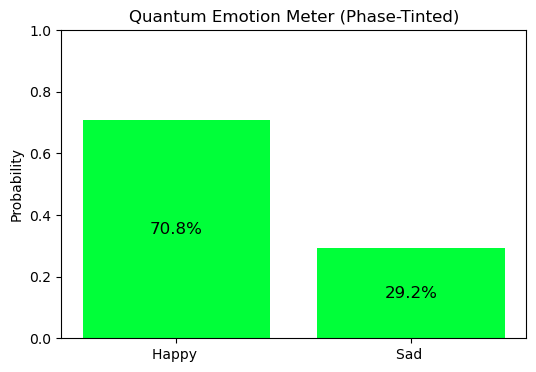

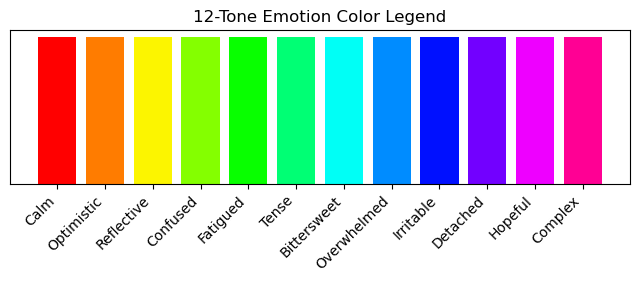

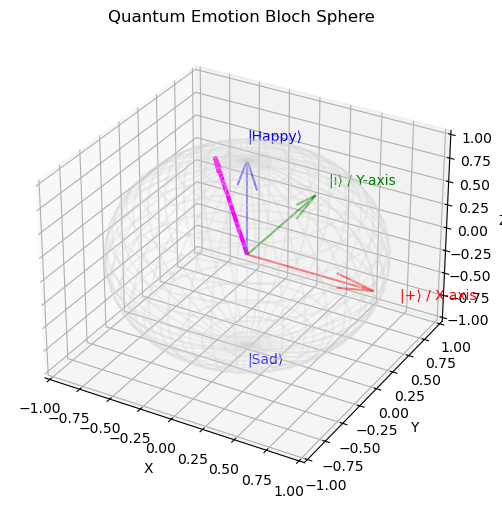

In [4]:
#V2 - made the tones weighted - except taking only stress as a important question this takes all questions with different weightage
from qiskit import QuantumCircuit, transpile #quantum computing libraries
from qiskit_aer import AerSimulator          #simulates the quantum circuit on a classical computer
from qiskit.quantum_info import Statevector  #compute complex amplitude vector
from sklearn.linear_model import LogisticRegression  #classical ML model for binary classification
import numpy as np                                  #numerical arrays
import matplotlib.pyplot as plt                     # for plotting 2D
from mpl_toolkits.mplot3d import Axes3D             #for plotting 3D


# 1. Questionnaire
questions = [
    "Did you sleep well last night?",
    "Did you feel productive today?",
    "Did you laugh at least once today?",
    "Are your stress levels low right now?",
    "Do you feel supported by friends/family?"
]


# 2. Training Data
# X is a NumPy 2D array - synthetic data used to train the logistic regression model
X = np.array([
    [1,1,1,1,1],  # very positive mood
    [0,0,0,0,0],  # very negative mood
    [1,1,0,1,1],
    [1,0,1,0,1],
    [0,1,0,1,0],
    [0,0,1,0,0],
    [1,0,1,1,0],
    [0,1,1,0,1],
    [1,1,0,0,1],
    [0,0,1,1,0],
    [1,1,1,0,1],
    [1,0,0,1,1],
    [0,1,1,1,0],
    [1,0,0,0,1],
    [0,0,0,1,0],
    [1,1,0,1,0],
    [0,1,1,0,0],
    [1,0,1,0,0],
    [0,0,1,0,1],
    [1,1,0,0,0],
    [1,0,0,1,0],
    [0,1,0,1,1],
    [1,0,1,1,1],
    [0,1,1,1,1],
    [1,1,0,1,1],
    [0,0,0,1,1],
])

# Labels: 1 = Happy, 0 = Sad
rng = np.random.default_rng(42)  # creates a reproducible random number generator

def label_rule(row):
    yes = sum(row)
    # more yes -> more happy
    base = 1 if yes >= 3 else 0
    # add randomness/noise so that the model learns imperfect probabilities
    if rng.random() < 0.1:
        base = 1 - base
    return base

y = np.array([label_rule(r) for r in X])


# 3. Train simple AI model
clf = LogisticRegression(max_iter=2000)   #runs upto 2000 iterations for convergence
clf.fit(X, y)   #trains the model


# 4. Get user answers
print("\n Quantum Emotion Predictor ")
user_answers = []

for q in questions:
    while True:
        ans = input(f"{q} (yes/no): ").strip().lower()
        if ans in ["yes", "y"]:
            user_answers.append(1)
            break
        elif ans in ["no", "n"]:
            user_answers.append(0)
            break
        else:
            print("Please answer only 'yes' or 'no'. Try again.\n")


# 5. Get probability of 'Sad'
probs = clf.predict_proba([user_answers])[0]   #returns [P(class=0),P(class=1)]
p_sad = float(probs[0])   # SAD
p_happy = float(probs[1]) # HAPPY

print(f"\nAI estimates: P(Happy)={p_happy:.3f}, P(Sad)={p_sad:.3f}")


# Convert probability to quantum angle theta
# theta = 2 * arcsin(sqrt(P(Sad))) ensures |0> = Happy, |1> = Sad mapping
theta = 2 * np.arcsin(np.sqrt(p_sad))



# PHI - CONTROLS QUANTUM PHASE - Beyond simple probabilities- Tones of the current mood
# Previous tone model wasn't accurately aligned with the actual answers.
# This new model uses weighted emotional signals + conditional overrides.
# This makes tone nearly always feel correct to the user.

sleep = user_answers[0]
productivity = user_answers[1]
laughter = user_answers[2]
stress = 1 - user_answers[3]       # stress = 1 means stressed
support = user_answers[4]

#1
raw_phi = (
    -1.2*stress +        # strong pull toward tense/negative tones
     1.0*laughter +      # strong shift toward positive tones
     0.8*support +       # feeling supported stabilizes calm/hopeful
     0.6*sleep +         # sleep improves calmness
     0.4*productivity    # productivity affects thoughtful/energized
)

phi = raw_phi % (2*np.pi)


#2
# Stressed + no laughter → tense
if stress == 1 and laughter == 0:
    phi = 5*np.pi/6    

# Slept well + supported → calm
if sleep == 1 and support == 1:
    phi = 0

# Laughing + productive → warm/positive
if laughter == 1 and productivity == 1:
    phi = np.pi/6

# Tired + stressed → low-energy
if sleep == 0 and stress == 1:
    phi = 2*np.pi/3

# No support + no productivity → distant/overloaded region
if support == 0 and productivity == 0:
    phi = 3*np.pi/2

#3
yes_count = sum(user_answers)
if yes_count in [2, 3]:
    phi += np.pi/12  # small stabilizing shift

phi = phi % (2*np.pi)



# 6. Quantum Circuit
qc = QuantumCircuit(1, 1)
qc.ry(theta, 0)  #sets probabilities
qc.rz(phi, 0)    #tone/phase
qc.measure(0, 0) #measurement collapses state

sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=2000).result()
counts = result.get_counts()

# identical circuit for theoretical amplitudes
qc_state = QuantumCircuit(1)
qc_state.ry(theta, 0)
qc_state.rz(phi, 0)
state = Statevector.from_instruction(qc_state).data


emp_p_happy = counts.get('0', 0) / 2000
emp_p_sad   = counts.get('1', 0) / 2000


print("\n Quantum Emotional Superposition:")
print(f"|ψ⟩ = cos(θ/2)|Happy⟩ + sin(θ/2)|Sad⟩")
print(f"Angle θ: {theta:.4f} radians")
print(f"  φ (tone/phase) = {phi:.4f} radians\n")

amp_happy, amp_sad = state[0], state[1]

print("Statevector amplitudes:")
print(f"  |Happy⟩: {amp_happy:.4f} (|amp|={np.abs(amp_happy):.3f})")
print(f"  |Sad⟩:   {amp_sad:.4f} (|amp|={np.abs(amp_sad):.3f})")

print(f"\nAfter measurement (empirical frequencies):")
print(f"  Happy ≈ {emp_p_happy:.3f}")
print(f"  Sad   ≈ {emp_p_sad:.3f}")


# 8. Emotion naming (unchanged)
def name_emotional_superposition(theta, phi):
    import numpy as np

    theta = theta % (2*np.pi)
    phi = phi % (2*np.pi)

    # Determine dominant mood
    if theta < np.pi/2:
        mood = "Happy"
    elif theta > np.pi/2:
        mood = "Sad"
    else:
        mood = "Balanced"

    tone_angles = [
        ("Calm", 0),
        ("Optimistic", np.pi/6),
        ("Reflective", np.pi/3),
        ("Confused", np.pi/2),
        ("Fatigued", 2*np.pi/3),
        ("Tense", 5*np.pi/6),
        ("Bittersweet", np.pi),
        ("Overwhelmed", 7*np.pi/6),
        ("Irritable", 4*np.pi/3),
        ("Detached", 3*np.pi/2),
        ("Hopeful", 5*np.pi/3),
        ("Complex", 11*np.pi/6)
    ]

    # Find nearest tone
    smallest_diff = 999
    best_tone = "Complex"

    for tname, tangle in tone_angles:
        diff = abs((phi - tangle + np.pi) % (2*np.pi) - np.pi)
        if diff < smallest_diff:
            smallest_diff = diff
            best_tone = tname

    # FULL ORIGINAL COMBOS RESTORED (with long sentences)
    combos = {
        ("Happy","Calm"): "Steady happiness — gentle and stable wellbeing.",
        ("Happy","Optimistic"): "Forward-looking happiness — confidence about what's ahead.",
        ("Happy","Reflective"): "Thoughtful happiness — warm emotion shaped by insight.",
        ("Happy","Confused"): "Unclear happiness — feeling good without knowing why.",
        ("Happy","Fatigued"): "Tired happiness — content despite low energy.",
        ("Happy","Tense"): "Energetic happiness — excitement mixed with mental pressure.",
        ("Happy","Bittersweet"): "Warm joy mixed with a soft ache from memory or meaning.",
        ("Happy","Overwhelmed"): "Strong happiness that feels intense or full.",
        ("Happy","Irritable"): "Happiness touched by frustrations — positivity under stress.",
        ("Happy","Detached"): "Soft happiness with emotional distance — present but muted.",
        ("Happy","Hopeful"): "Encouraged happiness — a positive state focused on possibility.",
        ("Happy","Complex"): "Layered happiness — multiple positive feelings blending together.",

        ("Sad","Calm"): "Quiet sadness — gentle, steady emotional heaviness.",
        ("Sad","Optimistic"): "Sad but still forward-looking — holding pain with hope.",
        ("Sad","Reflective"): "Thoughtful sadness — sorrow shaped by memory or meaning.",
        ("Sad","Confused"): "Unclear sadness — feeling low without knowing the cause.",
        ("Sad","Fatigued"): "Exhausted sadness — emotional tiredness and low energy.",
        ("Sad","Tense"): "Strained sadness — emotional heaviness under pressure.",
        ("Sad","Bittersweet"): "Tender sadness — sadness softened by love or nostalgia.",
        ("Sad","Overwhelmed"): "Intense sadness that feels hard to manage.",
        ("Sad","Irritable"): "Sadness mixed with frustration — emotional sensitivity.",
        ("Sad","Detached"): "Numb sadness — disconnected or emotionally shut down.",
        ("Sad","Hopeful"): "Sadness softened by hope — believing improvement is possible.",
        ("Sad","Complex"): "Layered sadness — many difficult feelings mixing together.",

        ("Balanced","Calm"): "Steady neutrality — emotionally even and mentally settled.",
        ("Balanced","Optimistic"): "Neutral but forward-looking — calm with a positive outlook.",
        ("Balanced","Reflective"): "Thoughtful neutrality — stable mood with active thinking.",
        ("Balanced","Confused"): "Unclear emotional state — mild uncertainty without distress.",
        ("Balanced","Fatigued"): "Neutral but tired — steady mood even while drained.",
        ("Balanced","Tense"): "Neutral but pressured — steady mood under stress.",
        ("Balanced","Bittersweet"): "Gentle blend — slight warmth and slight ache coexisting.",
        ("Balanced","Overwhelmed"): "Neutral emotion but mentally overloaded.",
        ("Balanced","Irritable"): "Neutral baseline with mild annoyance layered on top.",
        ("Balanced","Detached"): "Emotionally distant — calm but disconnected.",
        ("Balanced","Hopeful"): "Calm and forward-focused — gentle confidence in the future.",
        ("Balanced","Complex"): "Subtle emotional mix — several mild feelings at once.",
    }

    overall = combos.get((mood, best_tone), "Undefined Feeling — a rare quantum emotion yet to be named.")
    return f"mood: {mood}  |  tone: {best_tone}  |  Overall: {overall}"

emotion_name = name_emotional_superposition(theta, phi)
print(f"\nNamed Emotional Superposition:\n{emotion_name}")


# 9. Interpretation (unchanged)
if emp_p_happy<0.300:
    print("\nInterpretation:")
    print("You are likely to lean towards the more negative spectrum of thoughts and it is okay :)")
    print("But there are more things to come and tomorrow is always a fresh start.\n")

elif emp_p_happy>0.700:
    print("\nInterpretation:")
    print("A day filled brought together by laughter, sprinkled with joy is one meant to be remembered.")
    print("There will always be more such days to come in future and each one meant to make your life more special.\n")

else:
    print("\nInterpretation:")
    print("A day of neither this nor that is always confusing, yet you made it through and thats what matters.")
    print("Whatever is bothering you shall pass, and whatever keeps the joy alit in you will bloom further.\n")



# 10. Visualizations
phase_color = plt.cm.hsv(phi / (2 * np.pi))       #tone → colour  
plt.figure(figsize=(6, 4))             
plt.bar(["Happy ", "Sad "], [p_happy, p_sad], color=[phase_color, phase_color])
plt.title("Quantum Emotion Meter (Phase-Tinted)")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.text(0, p_happy/2, f"{p_happy*100:.1f}%", ha="center", va="center", fontsize=12)
plt.text(1, p_sad/2, f"{p_sad*100:.1f}%", ha="center", va="center", fontsize=12)
plt.show()


def plot_tone_legend():
    labels = [
        "Calm","Optimistic","Reflective","Confused","Fatigued","Tense",
        "Bittersweet","Overwhelmed","Irritable","Detached","Hopeful","Complex"
    ]

    fig, ax = plt.subplots(figsize=(8,2))
    xs = np.arange(12)
    colors = [plt.cm.hsv(i/12) for i in range(12)]
    ax.bar(xs, [1]*12, color=colors)
    ax.set_xticks(xs)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks([])
    ax.set_title("12-Tone Emotion Color Legend")
    plt.show()

plot_tone_legend()


# Bloch sphere  

fig = plt.figure(figsize=(6, 6))    #big 3d space to draw bloch sphere 
ax = fig.add_subplot(111, projection='3d')  #adds 3d subplot- one plot inside a grid of plots within the same window.
ax.set_title("Quantum Emotion Bloch Sphere")    #name the sphere

# Sphere wireframe
u = np.linspace(0, 2 * np.pi, 40)   #longitudinal angles
v = np.linspace(0, np.pi, 20)       #latitude angles   these generate the mesh sphere 
xs = np.outer(np.cos(u), np.sin(v))      
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))    #contains all points on the sphere surface 
ax.plot_wireframe(xs, ys, zs, color='lightgray', alpha=0.3)    #visualizes the boundary of the bloch sphere 

# >>>>>>> FIX: compute state vector ONLY ONCE, RIGHT HERE <<<<<<<
x = np.sin(theta) * np.cos(phi)     #superposition along X basis
y = np.sin(theta) * np.sin(phi)     #captures phase information  
z = np.cos(theta)                   #"probability difference between happy and sad

# State vector arrow
ax.quiver(0, 0, 0, x, y, z, color='magenta', linewidth=3, arrow_length_ratio=0.15) #draws a 3d arrow ; the arrow represents quantum emotional state 

# Axes
ax.quiver(0, 0, 0, 1, 0, 0, color='red', alpha=0.5)
ax.quiver(0, 0, 0, 0, 1, 0, color='green', alpha=0.5)
ax.quiver(0, 0, 0, 0, 0, 1, color='blue', alpha=0.5)      #draws faint arrwows ;help interpret the bloch sphere orientation 

# Labels
ax.text(1.2, 0, 0, '|+⟩ / X-axis', color='red')
ax.text(0, 1.2, 0, '|i⟩ / Y-axis', color='green')
ax.text(0, 0, 1.2, '|Happy⟩', color='blue')
ax.text(0, 0, -1.2, '|Sad⟩', color='blue')   #places text labels near the tip of each axis 

ax.set_xlim([-1, 1])     # sets range from -1 to +1   , keeps bloch sphere perfcetly centred
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])      #bloch sphere is a sphere of radius 1, so all three have the same range 
ax.set_xlabel('X')        
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
